In [1]:
# 1. Отключаем torch.compile / dynamo — чтобы избежать ошибки external_utils
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

# 2. Устанавливаем совместимые версии
!pip install -q "timm==0.9.16" "segmentation-models-pytorch==0.5.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install segmentation-models-pytorch

In [3]:
import kagglehub
import os
import glob
import random
from PIL import Image
import tifffile
from sklearn.model_selection import train_test_split

import numpy as np
import gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import iou_score, f1_score
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
dataset_path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [5]:
import os
import torch
from torch.utils.data import Dataset
import tifffile
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.Affine(
        translate_percent=(0.03, 0.03),  
        scale=(0.97, 1.03),              
        rotate=(-5, 5),                  
        p=0.5
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

class LGGDataset(Dataset):
    def __init__(self, patient_dirs, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform

        for patient_dir in patient_dirs:
            image_files = [
                os.path.join(patient_dir, f) 
                for f in os.listdir(patient_dir) 
                if "_mask.tif" not in f and f.endswith(".tif")
            ]
            for img_path in image_files:
                mask_path = img_path.replace(".tif", "_mask.tif")
                if os.path.exists(mask_path):  # на всякий случай
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = tifffile.imread(self.image_paths[idx]).astype(np.float32)
        mask = tifffile.imread(self.mask_paths[idx]).astype(np.float32)

        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)  

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  
            mask = augmented["mask"]    
            mask = mask.unsqueeze(0)    
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

In [6]:
root = os.path.join(dataset_path, "kaggle_3m")

patients = sorted([os.path.join(root, patient) for patient in os.listdir(root)])
patients = [patient for patient in patients if os.path.isdir(patient)]
random.shuffle(patients)

train_patients, val_patients = train_test_split(patients, test_size=0.3, random_state=42)

train_ds = LGGDataset(train_patients, transform=train_transform)
val_ds = LGGDataset(val_patients, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, drop_last=True)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

Train samples: 2725
Val samples: 1204


In [7]:
models = {
    "deeplab_resnet34": smp.DeepLabV3Plus(
        encoder_name='resnet34',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    ),
    "deeplab_efficientnet": smp.DeepLabV3Plus(
        encoder_name='efficientnet-b0',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    ),
    "deeplab_mobilenet": smp.DeepLabV3Plus(
        encoder_name='mobilenet_v2',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    )
}

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [8]:
metrics = {'deeplab_resnet34':[],'deeplab_efficientnet':[],'deeplab_mobilenet':[]}

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, path='best_model.pth'):
        self.patience = patience
        self.path = path
        self.best_score = -float('inf')
        self.counter = 0
        self.early_stop = False

    def step(self, val_score, model):
        if val_score > self.best_score:
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [10]:
def dice_loss (pred, true):
    dice = smp.losses.DiceLoss(mode='binary')
    bce = nn.BCEWithLogitsLoss()
    return dice(pred, true) + bce(pred, true)
device = 'cuda'
for name, model in models.items():
  model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4 )
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
  )
  print ("Training:", name)
  early_stopping = EarlyStopping(patience=5, path=f"{name}_best.pth")
  for epoch in range (50):
    model.train()
    total = 0
    loop_train = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    
    for image, mask in loop_train:
      image, mask = image.to(device), mask.to(device)
      pred = model(image)
      loss = dice_loss(pred, mask)
    
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
    
      total += loss.item()
    model.eval()
    losses = []
    ious = []
    dices = []
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
    
    for image, mask in loop_val:
      image, mask = image.to(device), mask.to(device)
      pred = model(image)
      loss = dice_loss(pred, mask)
    
      tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.int(), mode='binary', threshold=0.5)
      iou = iou_score(tp, fp, fn, tn, reduction="micro")
      dice = f1_score(tp, fp, fn, tn, reduction="micro")
    
      ious.append(iou.item())
      dices.append(dice.item())
      losses.append(loss.item())
    print(
            f"Epoch {(epoch+1):02d} | "
            f"train_loss={total / len(train_loader):.4f} | "
            f"val_loss={np.mean(losses):.4f} | "
            f"IoU={np.nanmean(ious):.4f} | "
            f"Dice={np.nanmean(dices):.4f}"
    )
    metrics[name].append((total / len(train_loader), np.mean(losses), np.nanmean(ious), np.nanmean(dices)))
    early_stopping.step(np.nanmean(dices), model)
    if early_stopping.early_stop:
        print("Early stopping activated!")
        break
    scheduler.step(np.mean(losses))







Training: deeplab_resnet34


Epoch 01 | train_loss=0.4838 | val_loss=0.3340 | IoU=0.4945 | Dice=0.5887


Epoch 02 | train_loss=0.2632 | val_loss=0.2522 | IoU=0.5922 | Dice=0.6906


Epoch 03 | train_loss=0.2200 | val_loss=0.2614 | IoU=0.5769 | Dice=0.6694


Epoch 04 | train_loss=0.1919 | val_loss=0.1945 | IoU=0.6480 | Dice=0.7423


Epoch 05 | train_loss=0.1682 | val_loss=0.2059 | IoU=0.6468 | Dice=0.7366


Epoch 06 | train_loss=0.1672 | val_loss=0.1859 | IoU=0.6761 | Dice=0.7595


Epoch 07 | train_loss=0.1594 | val_loss=0.1856 | IoU=0.6541 | Dice=0.7435


Epoch 08 | train_loss=0.1518 | val_loss=0.1910 | IoU=0.6423 | Dice=0.7332


Epoch 09 | train_loss=0.1436 | val_loss=0.1688 | IoU=0.6864 | Dice=0.7760


Epoch 10 | train_loss=0.1394 | val_loss=0.2042 | IoU=0.6603 | Dice=0.7476


Epoch 11 | train_loss=0.1340 | val_loss=0.1856 | IoU=0.6625 | Dice=0.7467


Epoch 12 | train_loss=0.1388 | val_loss=0.2011 | IoU=0.6631 | Dice=0.7482


Epoch 13 | train_loss=0.1275 | val_loss=0.1807 | IoU=0.6863 | Dice=0.7690


Epoch 14 | train_loss=0.1181 | val_loss=0.1877 | IoU=0.6804 | Dice=0.7625
Early stopping activated!
Training: deeplab_efficientnet


Epoch 01 | train_loss=0.4146 | val_loss=0.2561 | IoU=0.5805 | Dice=0.6811


Epoch 02 | train_loss=0.2188 | val_loss=0.2380 | IoU=0.5956 | Dice=0.6889


Epoch 03 | train_loss=0.1771 | val_loss=0.1894 | IoU=0.6632 | Dice=0.7544


Epoch 04 | train_loss=0.1592 | val_loss=0.2060 | IoU=0.6245 | Dice=0.7151


Epoch 05 | train_loss=0.1572 | val_loss=0.1775 | IoU=0.6769 | Dice=0.7634


Epoch 06 | train_loss=0.1445 | val_loss=0.1960 | IoU=0.6609 | Dice=0.7468


Epoch 07 | train_loss=0.1371 | val_loss=0.1808 | IoU=0.6826 | Dice=0.7693


Epoch 08 | train_loss=0.1386 | val_loss=0.1700 | IoU=0.6739 | Dice=0.7582


Epoch 09 | train_loss=0.1325 | val_loss=0.1752 | IoU=0.6796 | Dice=0.7640


Epoch 10 | train_loss=0.1284 | val_loss=0.1637 | IoU=0.6941 | Dice=0.7798


Epoch 11 | train_loss=0.1347 | val_loss=0.1614 | IoU=0.7050 | Dice=0.7883


Epoch 12 | train_loss=0.1270 | val_loss=0.1687 | IoU=0.6906 | Dice=0.7712


Epoch 13 | train_loss=0.1192 | val_loss=0.2012 | IoU=0.6648 | Dice=0.7449


Epoch 14 | train_loss=0.1148 | val_loss=0.1705 | IoU=0.6669 | Dice=0.7513


Epoch 15 | train_loss=0.1125 | val_loss=0.1664 | IoU=0.6927 | Dice=0.7752


Epoch 16 | train_loss=0.1086 | val_loss=0.1845 | IoU=0.6855 | Dice=0.7696
Early stopping activated!
Training: deeplab_mobilenet


Epoch 01 | train_loss=0.4516 | val_loss=0.2924 | IoU=0.5469 | Dice=0.6400


Epoch 02 | train_loss=0.2254 | val_loss=0.2473 | IoU=0.5873 | Dice=0.6833


Epoch 03 | train_loss=0.1831 | val_loss=0.2240 | IoU=0.6160 | Dice=0.7031


Epoch 04 | train_loss=0.1834 | val_loss=0.2755 | IoU=0.5771 | Dice=0.6591


Epoch 05 | train_loss=0.1604 | val_loss=0.2167 | IoU=0.6445 | Dice=0.7344


Epoch 06 | train_loss=0.1434 | val_loss=0.2119 | IoU=0.6404 | Dice=0.7229


Epoch 07 | train_loss=0.1530 | val_loss=0.1936 | IoU=0.6680 | Dice=0.7561


Epoch 08 | train_loss=0.1522 | val_loss=0.2122 | IoU=0.6595 | Dice=0.7422


Epoch 09 | train_loss=0.1408 | val_loss=0.2654 | IoU=0.6107 | Dice=0.6926


Epoch 10 | train_loss=0.1413 | val_loss=0.1973 | IoU=0.6678 | Dice=0.7504


Epoch 11 | train_loss=0.1255 | val_loss=0.2090 | IoU=0.6666 | Dice=0.7446


Epoch 12 | train_loss=0.1176 | val_loss=0.1905 | IoU=0.6800 | Dice=0.7624


Epoch 13 | train_loss=0.1204 | val_loss=0.1898 | IoU=0.6901 | Dice=0.7683


Epoch 14 | train_loss=0.1117 | val_loss=0.2248 | IoU=0.6500 | Dice=0.7274


Epoch 15 | train_loss=0.1173 | val_loss=0.1998 | IoU=0.6758 | Dice=0.7537


Epoch 16 | train_loss=0.1161 | val_loss=0.1930 | IoU=0.6786 | Dice=0.7586


Epoch 17 | train_loss=0.1077 | val_loss=0.1863 | IoU=0.6883 | Dice=0.7666


Epoch 18 | train_loss=0.1064 | val_loss=0.1929 | IoU=0.6820 | Dice=0.7597
Early stopping activated!


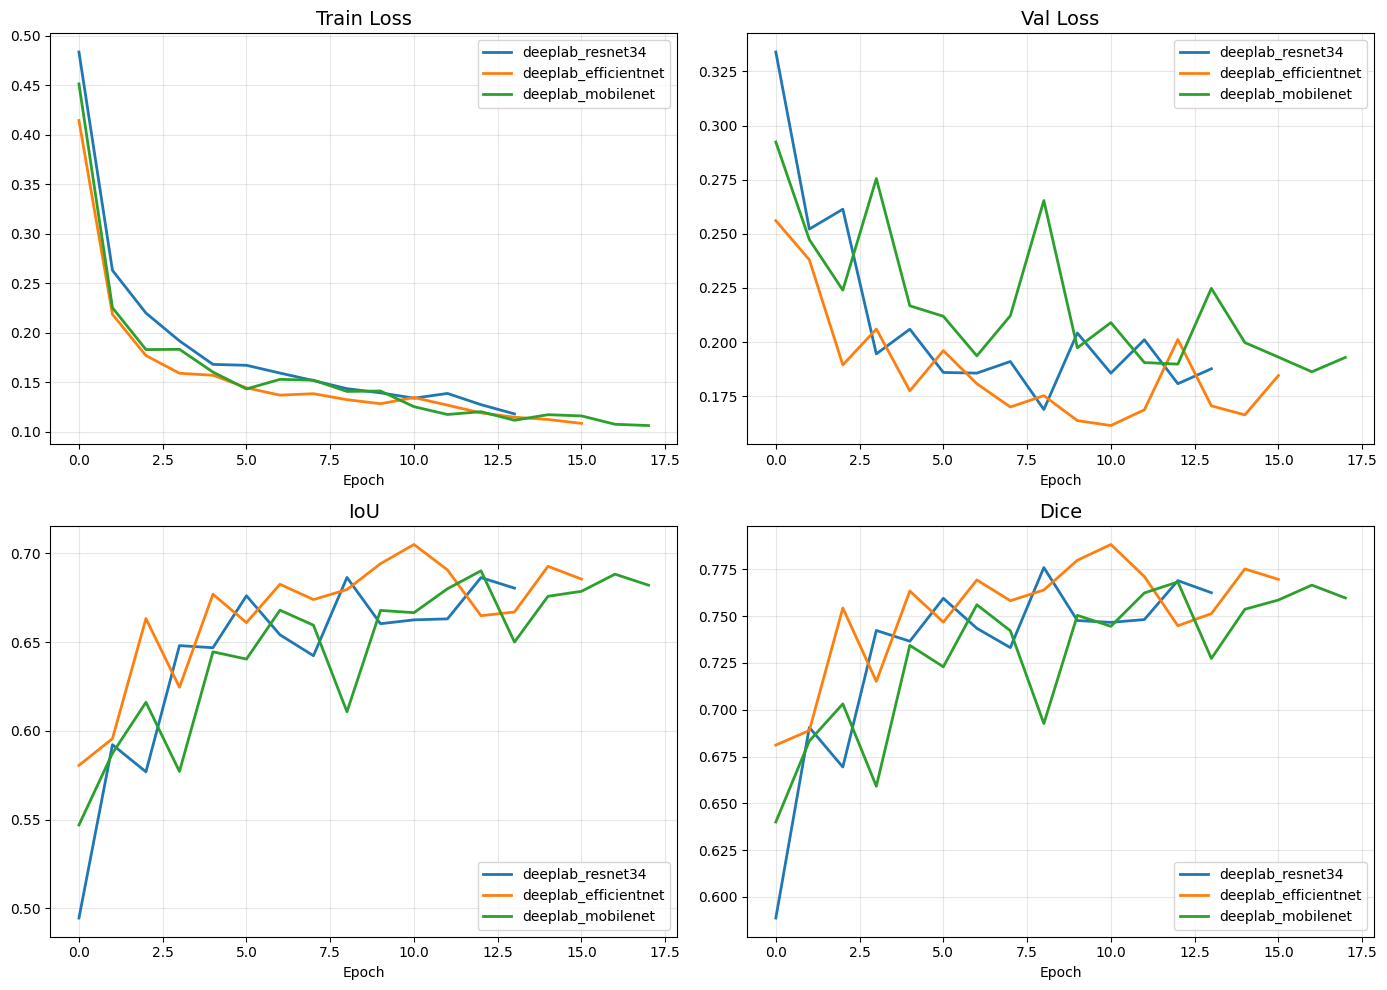

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

titles = ["Train Loss", "Val Loss", "IoU", "Dice"]
metric_idx = [0, 1, 2, 3]

for ax, title, idx in zip(axs, titles, metric_idx):
    for model in metrics.keys():
        values = [epoch[idx] for epoch in metrics[model]]
        ax.plot(values, label=model, linewidth=2)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
for name, model in models.items():
    starter = torch.cuda.Event(enable_timing=True)
    ender   = torch.cuda.Event(enable_timing=True)
    
    repeats = 1000
    model.to('cuda')
    model.eval()
    
    for img, mask in train_loader:
        img, mask = img.to('cuda'), mask.to('cuda')
    
        with torch.no_grad():
            starter.record()
            for _ in range(repeats):
                model(img)
            ender.record()
        
        torch.cuda.synchronize()
        total_time = starter.elapsed_time(ender)  
        latency = total_time / repeats
        
        print(f"Encoder: {name}, Latency: {latency:.3f} ms")
        break

Encoder: deeplab_resnet34, Latency: 12.135 ms
Encoder: deeplab_efficientnet, Latency: 10.030 ms
Encoder: deeplab_mobilenet, Latency: 7.525 ms
